In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
import math

In [78]:
DataSet_root = "./LIDC-IDRI"
Processed_data_dir = './data'
IMAGE_DIR = Processed_data_dir+ "/Image"
MASK_DIR = Processed_data_dir +"/Mask"
Clean_IMAGE_DIR =Processed_data_dir + '/CleanIMAGE'
Clean_MASK_DIR = Processed_data_dir +'/CleanMASK'
mask_thresh = 8

In [79]:
dataset = pd.read_csv(Processed_data_dir + '/dataset.csv')

In [80]:
dataset[dataset["is_cancer"]=='False']

,patient_id,nodule_no,slice_no,orignal_image,segmented_image,mask_image,malignancy,is_cancer,is_clean,original_image
36,3,0,62,NaN,./data/IMAGE/LIDC-IDRI-0003/Nodule0Slice62.npy,./data/MASK/LIDC-IDRI-0003/Mask0Slice62.npy,2,False,False,./data/IMAGE/LIDC-IDRI-0003/Orignal0Slice62.png
37,3,0,63,NaN,./data/IMAGE/LIDC-IDRI-0003/Nodule0Slice63.npy,./data/MASK/LIDC-IDRI-0003/Mask0Slice63.npy,2,False,False,./data/IMAGE/LIDC-IDRI-0003/Orignal0Slice63.png
38,3,0,64,NaN,./data/IMAGE/LIDC-IDRI-0003/Nodule0Slice64.npy,./data/MASK/LIDC-IDRI-0003/Mask0Slice64.npy,2,False,False,./data/IMAGE/LIDC-IDRI-0003/Orignal0Slice64.png
39,3,0,65,NaN,./data/IMAGE/LIDC-IDRI-0003/Nodule0Slice65.npy,./data/MASK/LIDC-IDRI-0003/Mask0Slice65.npy,2,False,False,./data/IMAGE/LIDC-IDRI-0003/Orignal0Slice65.png
40,3,0,66,NaN,./data/IMAGE/LIDC-IDRI-0003/Nodule0Slice66.npy,./data/MASK/LIDC-IDRI-0003/Mask0Slice66.npy,2,False,False,./data/IMAGE/LIDC-IDRI-0003/Orignal0Slice66.png
...,...,...,...,...,...,...,...,...,...,...
2227,159,0,71,NaN,./data/IMAGE/LIDC-IDRI-0159/Nodule0Slice71.npy,./data/MASK/LIDC-IDRI-0159/Mask0Slice71.npy,1,False,False,./data/IMAGE/LIDC-IDRI-0159/Orignal0Slice71.png
2234,160,0,50,NaN,./data/IMAGE/LIDC-IDRI-0160/Nodule0Slice50.npy,./data/MASK/LIDC-IDRI-0160/Mask0Slice50.npy,1,False,False,./data/IMAGE/LIDC-IDRI-0160/Orignal0Slice50.png
2235,160,0,51,NaN,./data/IMAGE/LIDC-IDRI-0160/Nodule0Slice51.npy,./data/MASK/LIDC-IDRI-0160/Mask0Slice51.npy,1,False,False,./data/IMAGE/LIDC-IDRI-0160/Orignal0Slice51.png
2236,160,0,52,NaN,./data/IMAGE/LIDC-IDRI-0160/Nodule0Slice52.npy,./data/MASK/LIDC-IDRI-0160/Mask0Slice52.npy,1,False,False,./data/IMAGE/LIDC-IDRI-0160/Orignal0Slice52.png


In [81]:
dataset["is_cancer"].value_counts()

True         1080
Ambiguous     732
False         438
Name: is_cancer, dtype: int64

In [82]:
dataset[dataset["is_cancer"]=="Ambiguous"].count()

patient_id         732
nodule_no          732
slice_no           732
orignal_image        0
segmented_image    732
mask_image         732
malignancy         732
is_cancer          732
is_clean           732
original_image     732
dtype: int64

In [83]:
def balance_dataset(dataset):
    balance_count = min(dataset[dataset["is_cancer"]=="False"].count()[0],min(dataset[dataset["is_cancer"]=="True"].count()[0],dataset[dataset["is_cancer"]=="Ambiguous"].count()[0]))
    sampled_ds = pd.DataFrame(index=[],columns=['patient_id','nodule_no','slice_no','original_image','segmented_image','mask_image','malignancy','is_cancer','is_clean'])
    sampled_ds = sampled_ds.append(dataset[dataset["is_cancer"]=="Ambiguous"].sample(balance_count))
    sampled_ds = sampled_ds.append(dataset[dataset["is_cancer"]=="True"].sample(balance_count*2))
    sampled_ds = sampled_ds.append(dataset[dataset["is_cancer"]=="False"].sample(balance_count))
    sampled_ds = sampled_ds.reset_index()
    sampled_ds = sampled_ds.sample(balance_count*4)
    return sampled_ds

In [84]:

balanced_ds = balance_dataset(dataset)
balanced_ds

,index,patient_id,nodule_no,slice_no,original_image,segmented_image,mask_image,malignancy,is_cancer,is_clean,orignal_image
1726,1943,138,0,197,./data/IMAGE/LIDC-IDRI-0138/Orignal0Slice197.png,./data/IMAGE/LIDC-IDRI-0138/Nodule0Slice197.npy,./data/MASK/LIDC-IDRI-0138/Mask0Slice197.npy,1,False,False,NaN
331,1315,91,3,151,./data/IMAGE/LIDC-IDRI-0091/Orignal3Slice151.png,./data/IMAGE/LIDC-IDRI-0091/Nodule3Slice151.npy,./data/MASK/LIDC-IDRI-0091/Mask3Slice151.npy,3,Ambiguous,False,NaN
387,917,64,0,74,./data/IMAGE/LIDC-IDRI-0064/Orignal0Slice74.png,./data/IMAGE/LIDC-IDRI-0064/Nodule0Slice74.npy,./data/MASK/LIDC-IDRI-0064/Mask0Slice74.npy,3,Ambiguous,False,NaN
1746,675,49,11,69,./data/IMAGE/LIDC-IDRI-0049/Orignal11Slice69.png,./data/IMAGE/LIDC-IDRI-0049/Nodule11Slice69.npy,./data/MASK/LIDC-IDRI-0049/Mask11Slice69.npy,2,False,False,NaN
349,1605,120,0,65,./data/IMAGE/LIDC-IDRI-0120/Orignal0Slice65.png,./data/IMAGE/LIDC-IDRI-0120/Nodule0Slice65.npy,./data/MASK/LIDC-IDRI-0120/Mask0Slice65.npy,3,Ambiguous,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1005,1188,80,0,79,./data/IMAGE/LIDC-IDRI-0080/Orignal0Slice79.png,./data/IMAGE/LIDC-IDRI-0080/Nodule0Slice79.npy,./data/MASK/LIDC-IDRI-0080/Mask0Slice79.npy,4,True,False,NaN
1262,717,52,1,225,./data/IMAGE/LIDC-IDRI-0052/Orignal1Slice225.png,./data/IMAGE/LIDC-IDRI-0052/Nodule1Slice225.npy,./data/MASK/LIDC-IDRI-0052/Mask1Slice225.npy,5,True,False,NaN
487,1204,80,1,97,./data/IMAGE/LIDC-IDRI-0080/Orignal1Slice97.png,./data/IMAGE/LIDC-IDRI-0080/Nodule1Slice97.npy,./data/MASK/LIDC-IDRI-0080/Mask1Slice97.npy,5,True,False,NaN
698,736,53,1,48,./data/IMAGE/LIDC-IDRI-0053/Orignal1Slice48.png,./data/IMAGE/LIDC-IDRI-0053/Nodule1Slice48.npy,./data/MASK/LIDC-IDRI-0053/Mask1Slice48.npy,4,True,False,NaN


In [85]:
reduced_ds = balanced_ds.drop(columns=["index","patient_id","nodule_no","slice_no","malignancy","is_clean","mask_image"])


In [86]:
lbl = LabelEncoder()
enc = OneHotEncoder()

labels = lbl.fit_transform(reduced_ds["is_cancer"].values.reshape(-1,1))
reduced_ds['labels'] = labels

C:\ProgramData\Anaconda3\envs\Lung-Cancer-Detection\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [87]:
reduced_ds.reset_index(drop=True,inplace=True)

dataset = tf.data.Dataset.from_tensor_slices((reduced_ds['segmented_image'], reduced_ds['labels']))

In [88]:
size = 256

def getImg(Img):
    img = tf.image.decode_png(Img)
    #img = tf.cast(img/255,tf.float32)
    img = tf.image.resize(img,(size,size))
    img = tf.image.per_image_standardization(img)

    #img = img/255
    return img
def getFile(orignal_image,label):
    #img = np.load(orignal_image)
    #img = tf.io.read_file(orignal_image)
    #img = getImg(img)
    img = tf.numpy_function(read_npy_file, inp=[orignal_image], Tout=(tf.float32))
    img.set_shape((512,512,1))
    
    img = tf.image.resize(img,(size,size))
   # img = tf.image.per_image_standardization(img)

    return img,label
def read_npy_file(item):
    data = np.load(item)
    data = data.reshape((512,512,1))
    
    
    return data.astype(np.float32)

In [89]:
dataset = dataset.map(getFile)

In [90]:
len_ds = reduced_ds.shape[0]
batch_size = 64
split_size = 0.8
def createTrainTest(ds):
    ds = ds.shuffle(50)
    train_ds = ds.take(math.floor(len_ds*split_size))
    test_ds = ds.skip(math.floor(len_ds*split_size)).take(math.floor(len_ds*(1-split_size)))
    train_ds = train_ds.batch(batch_size)
    test_ds = test_ds.batch(batch_size)
    

    return train_ds,test_ds
def plot(history):
    fig,(axs1,axs2) = plt.subplots(2)
    axs1.plot(history['loss'])
    axs1.plot(history['val_loss'])
    axs1.legend(['loss','val_loss'])
    axs1.set_title("training loss")
    axs2.plot(history['acc'])
    axs2.plot(history['val_acc'])
    axs2.set_title("testing acc")
    axs2.legend(['acc','val_acc'])
    
    plt.show()

In [91]:
AUTOTUNE = 4
train_ds,test_ds = createTrainTest(dataset)
train_ds = train_ds.cache().prefetch(AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)


In [93]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Softmax,ReLU,Flatten,MaxPooling2D,Dropout,LeakyReLU



In [42]:
baseline = Sequential([
Conv2D(32,(3,3),activation = 'relu',input_shape = (size,size,1)),
Conv2D(16, 3, padding='same', activation='relu'),
 MaxPooling2D(),
  Conv2D(32, 3, padding='same', activation='relu'),
 MaxPooling2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
 Flatten(),
  Dense(128, activation='relu'),
 Dense(3,activation='softmax'),
 
])
baseline.summary()
baseline.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics = ['acc'])
history = baseline.fit(train_ds,epochs=10,validation_data=test_ds)
baseline.save("baseline")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 254, 254, 32)      320       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 254, 254, 16)      4624      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 127, 127, 32)      4640      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 63, 63, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 31, 31, 64)       

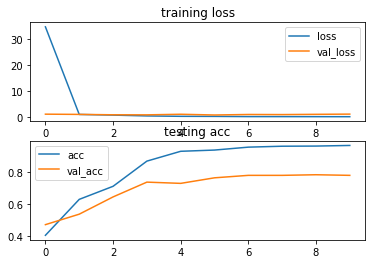

In [43]:

plot(history.history)

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_93 (Conv2D)           (None, 254, 254, 32)      320       
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 254, 254, 32)      9248      
_________________________________________________________________
max_pooling2d_76 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 127, 127, 64)      18496     
_________________________________________________________________
max_pooling2d_77 (MaxPooling (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 63, 63, 64)        36928     
_________________________________________________________________
max_pooling2d_78 (MaxPooling (None, 31, 31, 64)      

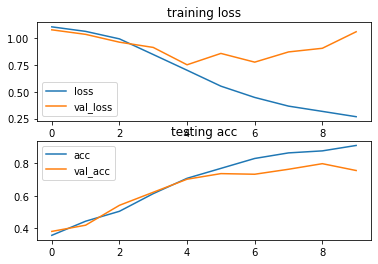

In [157]:
testing1 = Sequential([
Conv2D(32,(3,3),activation = 'relu',input_shape = (size,size,1)),
Conv2D(32, 3, padding='same', activation='relu'),
 MaxPooling2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
 MaxPooling2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
Conv2D(128, 3, padding='same', activation='relu'),
  MaxPooling2D(),
 Flatten(),
  Dense(64, activation='relu'),
 Dense(3,activation='softmax'),
 
])
testing1.summary()
testing1.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics = ['acc'])
history1 = testing1.fit(train_ds,epochs=10,validation_data=test_ds)
plot(history1.history)

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_99 (Conv2D)           (None, 254, 254, 16)      160       
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 254, 254, 32)      4640      
_________________________________________________________________
max_pooling2d_81 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 127, 127, 64)      18496     
_________________________________________________________________
max_pooling2d_82 (MaxPooling (None, 63, 63, 64)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 63, 63, 64)      

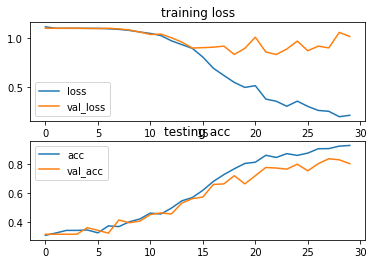

In [158]:
testing2 = Sequential([
Conv2D(16,(3,3),activation = 'relu',input_shape = (256,256,1)),
Conv2D(32, 3, padding='same', activation='relu'),
 MaxPooling2D(),
    Dropout(0.2),
Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
    Dropout(0.2),
    Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
    Dropout(0.2),
Conv2D(128, 3, padding='same', activation='relu'),
  MaxPooling2D(),
    Dropout(0.2),
    Conv2D(128, 3, padding='same', activation='relu'),
  MaxPooling2D(),
    Dropout(0.2),
    Conv2D(254, 3, padding='same', activation='relu'),
  MaxPooling2D(),
 Flatten(),
  Dense(521, activation='relu'),
    Dense(128, activation='relu'),
 Dense(3,activation='softmax'),
 
])
testing2.summary()
testing2.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics = ['acc'])
history2 = testing2.fit(train_ds,epochs=30,validation_data=test_ds)
plot(history2.history)

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_106 (Conv2D)          (None, 254, 254, 32)      320       
_________________________________________________________________
max_pooling2d_87 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 127, 127, 64)      18496     
_________________________________________________________________
max_pooling2d_88 (MaxPooling (None, 63, 63, 64)        0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_108 (Conv2D)          (None, 63, 63, 128)     

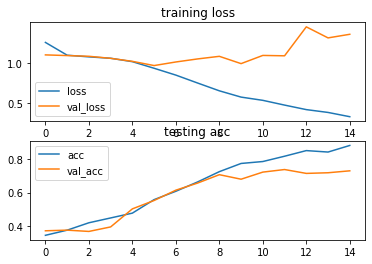

In [159]:
testing3 = Sequential([
Conv2D(32,(3,3),activation = 'relu',input_shape = (size,size,1)),
     MaxPooling2D(),
    Dropout(0.2),
Conv2D(64, 3, padding='same', activation='relu'),
 MaxPooling2D(),
    Dropout(0.2),
Conv2D(128, 3, padding='same', activation='relu'),
  MaxPooling2D(),
    Dropout(0.2),
    Conv2D(128, 3, padding='same', activation='relu'),
  MaxPooling2D(),
 Dropout(0.2),
    Conv2D(254, 3, padding='same', activation='relu'),
  MaxPooling2D(),
 Flatten(),

    Dense(128, activation='relu'),
 Dense(3,activation='softmax'),
 
])
testing3.summary()
testing3.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics = ['acc'])
history3 = testing3.fit(train_ds,epochs=15,validation_data=test_ds)
plot(history3.history)

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_111 (Conv2D)          (None, 254, 254, 32)      320       
_________________________________________________________________
max_pooling2d_92 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_112 (Conv2D)          (None, 127, 127, 64)      18496     
_________________________________________________________________
max_pooling2d_93 (MaxPooling (None, 63, 63, 64)        0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_113 (Conv2D)          (None, 63, 63, 128)     

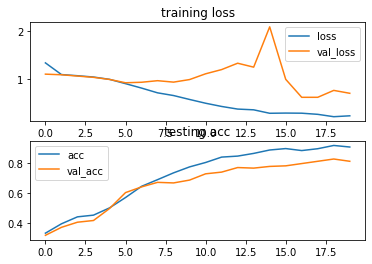

In [160]:
testing4 = Sequential([
Conv2D(32,(3,3),activation = 'relu',input_shape = (size,size,1)),
     MaxPooling2D(),
    Dropout(0.2),
Conv2D(64, 3, padding='same', activation='relu'),
 MaxPooling2D(),
    Dropout(0.2),
Conv2D(128, 3, padding='same', activation='relu'),
  MaxPooling2D(),
    Dropout(0.2),
    Conv2D(128, 3, padding='same', activation='relu'),
  MaxPooling2D(),
 Dropout(0.2),
    Conv2D(254, 3, padding='same', activation='relu'),
  MaxPooling2D(),
 Flatten(),
Dense(128, activation='relu'),
 Dense(3,activation='softmax'),
 
])
testing4.summary()
testing4.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics = ['acc'])
history4 = testing4.fit(train_ds,epochs=20,validation_data=test_ds)
plot(history4.history)

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_116 (Conv2D)          (None, 254, 254, 32)      320       
_________________________________________________________________
max_pooling2d_97 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_117 (Conv2D)          (None, 127, 127, 64)      18496     
_________________________________________________________________
max_pooling2d_98 (MaxPooling (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_118 (Conv2D)          (None, 63, 63, 128)       73856     
_________________________________________________________________
max_pooling2d_99 (MaxPooling (None, 31, 31, 128)       0         
_________________________________________________________________
conv2d_119 (Conv2D)          (None, 31, 31, 128)     

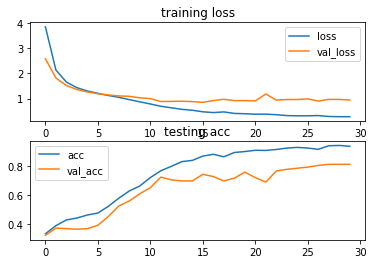

In [161]:
#with l2
testing5 = Sequential([
Conv2D(32,(3,3),activation = 'relu',input_shape = (256,256,1),kernel_regularizer=tf.keras.regularizers.l2()),
     MaxPooling2D(),
    
Conv2D(64, 3, padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2()),
 MaxPooling2D(),
    
Conv2D(128, 3, padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2()),
  MaxPooling2D(),
   
    Conv2D(128, 3, padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2()),
  MaxPooling2D(),

    Conv2D(254, 3, padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2()),
  MaxPooling2D(),
 Flatten(),
Dense(128, activation='relu'),
 Dense(3,activation='softmax'),
 
])
testing5.summary()
testing5.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics = ['acc'])
history5 = testing5.fit(train_ds,epochs=30,validation_data=test_ds)
plot(history5.history)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_51 (Conv2D)           (None, 254, 254, 16)      160       
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 127, 127, 16)      0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 127, 127, 32)      4640      
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 63, 63, 128)     

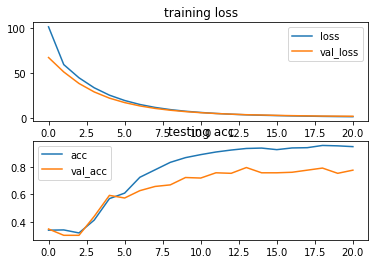

In [40]:
#l1 and dropout
l1_constraint = 0.3
dropout_constraint = 0.4
testing5 = Sequential([
Conv2D(16,(3,3),activation = 'relu',input_shape = (size,size,1),kernel_regularizer=tf.keras.regularizers.l2(l=l1_constraint)),
     MaxPooling2D(),
    Dropout(dropout_constraint),
Conv2D(32, 3, padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l=l1_constraint)),
 MaxPooling2D(),
    Dropout(dropout_constraint),

    Conv2D(128, 3, padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l=l1_constraint)),
  MaxPooling2D(),
Dropout(dropout_constraint),
    Conv2D(256, 3, padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l=l1_constraint)),
  MaxPooling2D(),
 Flatten(),
Dense(128, activation='relu'),
 Dense(3,activation='softmax'),
 
])
testing5.summary()
testing5.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics = ['acc'])
history5 = testing5.fit(train_ds,epochs=21,validation_data=test_ds)
plot(history5.history)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 254, 254, 16)      160       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 127, 127, 16)      0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 127, 127, 32)      4640      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 63, 63, 128)      

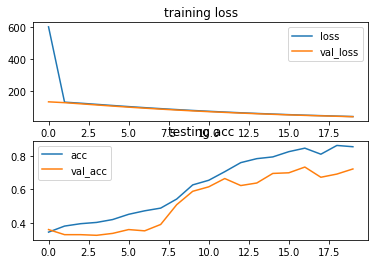

In [25]:
#l1 and dropout
l1_constraint = 0.5
dropout_constraint = 0.5
testing5 = Sequential([
Conv2D(16,(3,3),activation = 'relu',input_shape = (size,size,1),kernel_regularizer=tf.keras.regularizers.l2(l=l1_constraint)),
     MaxPooling2D(),
    Dropout(dropout_constraint),
Conv2D(32, 3, padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l=l1_constraint)),
 MaxPooling2D(),
    Dropout(dropout_constraint),

    Conv2D(128, 3, padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l=l1_constraint)),
  MaxPooling2D(),
Dropout(dropout_constraint),
    Conv2D(256, 3, padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l=l1_constraint)),
  MaxPooling2D(),
 Flatten(),
Dense(128, activation='relu'),
 Dense(3,activation='softmax'),
 
])
testing5.summary()
testing5.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics = ['acc'])
history5 = testing5.fit(train_ds,epochs=20,validation_data=test_ds)
plot(history5.history)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 254, 254, 32)      320       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 127, 127, 64)      18496     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 63, 63, 64)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 63, 63, 128)      

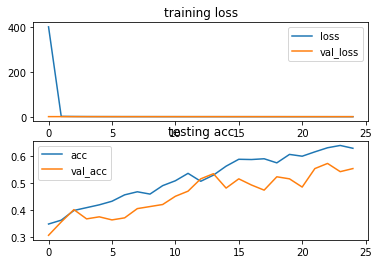

In [27]:
#l1 l2,and dropout
l1_constraint = 0
l2_constraint = 0
dropout_constraint = 0.5
testing5 = Sequential([
Conv2D(32,(3,3),activation = 'relu',input_shape = (size,size,1),kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_constraint,l2=l2_constraint)),
     MaxPooling2D(),
    Dropout(dropout_constraint),
Conv2D(64, 3, padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_constraint,l2=l2_constraint)),
 MaxPooling2D(),
    Dropout(dropout_constraint),

    Conv2D(128, 3, padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_constraint,l2=l2_constraint)),
  MaxPooling2D(),
Dropout(dropout_constraint),
    Conv2D(128, 3, padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_constraint,l2=l2_constraint)),
  MaxPooling2D(),
Dropout(dropout_constraint),
 Flatten(),
Dense(256, activation='relu'),
 Dense(3,activation='softmax'),
 
])
testing5.summary()
testing5.compile(optimizer='nadam',loss='sparse_categorical_crossentropy',metrics = ['acc'])
history5 = testing5.fit(train_ds,epochs=25,validation_data=test_ds)
plot(history5.history)
#testing5.save("./testing82_training92/")

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_96 (Conv2D)           (None, 254, 254, 32)      320       
_________________________________________________________________
max_pooling2d_96 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
dropout_99 (Dropout)         (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 127, 127, 64)      18496     
_________________________________________________________________
max_pooling2d_97 (MaxPooling (None, 63, 63, 64)        0         
_________________________________________________________________
dropout_100 (Dropout)        (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 63, 63, 128)     

22/22 [==============================] - 3s 154ms/step - loss: 28.4746 - acc: 0.8323 - val_loss: 28.0547 - val_acc: 0.8143
Epoch 44/100
22/22 [==============================] - 3s 153ms/step - loss: 27.5636 - acc: 0.8408 - val_loss: 27.1749 - val_acc: 0.8114
Epoch 45/100
22/22 [==============================] - 3s 153ms/step - loss: 26.6559 - acc: 0.8565 - val_loss: 26.2996 - val_acc: 0.8314
Epoch 46/100
22/22 [==============================] - 3s 153ms/step - loss: 25.8272 - acc: 0.8765 - val_loss: 25.4764 - val_acc: 0.8343
Epoch 47/100
22/22 [==============================] - 3s 153ms/step - loss: 25.0740 - acc: 0.8565 - val_loss: 24.7552 - val_acc: 0.8114
Epoch 48/100
22/22 [==============================] - 3s 153ms/step - loss: 24.2563 - acc: 0.8808 - val_loss: 23.9663 - val_acc: 0.8429
Epoch 49/100
22/22 [==============================] - 3s 155ms/step - loss: 23.5670 - acc: 0.8572 - val_loss: 23.2917 - val_acc: 0.8457
Epoch 50/100
22/22 [==============================] - 4s 162m

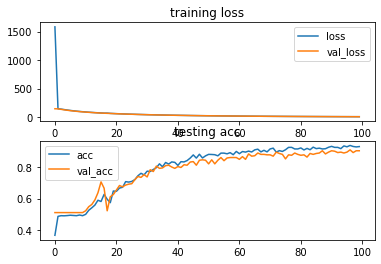

In [103]:
#l1 l2,and dropout
l1_constraint = 0
l2_constraint = 0.4
dropout_constraint = 0.42
testing6 = Sequential([
    
Conv2D(32,(3,3),activation = 'relu',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_constraint,l2=l2_constraint),input_shape = (size,size,1)),
     MaxPooling2D(),
    Dropout(dropout_constraint),
Conv2D(64, 3, padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_constraint,l2=l2_constraint)),
 MaxPooling2D(),
    Dropout(dropout_constraint),

    Conv2D(128, 3, padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_constraint,l2=l2_constraint)),
  MaxPooling2D(),
Dropout(dropout_constraint),
    Conv2D(256, 3, padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_constraint,l2=l2_constraint)),
  MaxPooling2D(),
Dropout(dropout_constraint),
 Flatten(),
Dense(350, activation='relu'),
 Dense(3,activation='softmax'),
 
])
testing6.summary()
testing6.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0022),loss='sparse_categorical_crossentropy',metrics = ['acc'])
history6 = testing6.fit(train_ds,epochs=100,validation_data=test_ds)
plot(history6.history)


In [104]:
testing6.save("./acc89_valacc84-2/")

INFO:tensorflow:Assets written to: ./acc89_valacc84-2/assets


In [40]:
import pickle
pickle.dump(lbl,open("label_encoder","wb"))

In [44]:
lbl = pickle.load(open("label_encoder","rb"))


In [49]:
lbl.inverse_transform()

'True'

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 254, 254, 32)      320       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 127, 127, 64)      18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 63, 63, 64)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 63, 63, 256)      

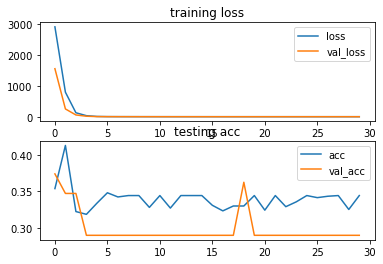